In [1]:
# import the packages we'll use for data processing
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xarray as xr
from netCDF4 import Dataset

In [2]:
def load_eofs(filename):
    ds = Dataset(filename, 'r')
    neof = np.arange(20)
    times = np.arange(1980,2018)
    pcs = np.array(ds.variables['pc'][:])
    df = pd.DataFrame(pcs, index=times)
    return df

In [3]:
def load_temp_data(filename):
    square_df = pd.read_csv(filename, index_col='year')
    square_df = square_df.drop(columns=['lat', 'lon'])
    df = pd.Series(square_df.values.ravel(), 
                   index=pd.date_range('1979-01', '2018-01', freq='M'))
    df = df.truncate(before='1979-10-01', after='2017-10-01')
    return df

In [54]:
pc_file = '/gpfs/fs1/work/bitz/WPO2019/PrepareERAiT2m/T2m_ERAi_inputs_1980to2017WaterYear.csv'
df = pd.read_csv(pc_file)
df.index = pd.date_range(start='10-1979', end='10-2017', freq='M')

In [66]:
station_location = 'GUC'
filename = '/glade/work/acback/WPO2019/%s.csv' % station_location
obs_df = load_temp_data(filename)
obs = obs_df.values

In [67]:
num_targets = 2

In [68]:
# create the data frame where you'll store the principle components
column_names = []
features=11
for i in range(1,features):
    column_names.append('pc'+str(i))
column_names.append('RegionalMean')
index = pd.date_range(start='10-01-1979', end='10-01-2017', freq='M')
df = pd.DataFrame(data=df[column_names].values, columns=column_names, index=index)
df['target'] = obs

In [100]:
# the date at which you want to split the timeseries into training and test data
split_date = '2004-10-01'
train = df.truncate(after=split_date)
test = df.truncate(before=split_date)

In [105]:
# Instantiate model 
rf = RandomForestRegressor(n_estimators=1000, random_state=41)
# Train the model on training data
rf.fit(train[column_names].values , train[['target']].values.squeeze());

In [111]:
test['fit'] = rf.predict(test[column_names])

In [113]:
test_r2 = rf.score(test[column_names], test['target'])
train_r2 = rf.score(train[column_names], train['target'])
print('Training R^2 is: %s' % train_r2)
print('Test R^2 is: %s' % test_r2)

Training R^2 is: 0.9056209437318008
Test R^2 is: 0.20759021289167667


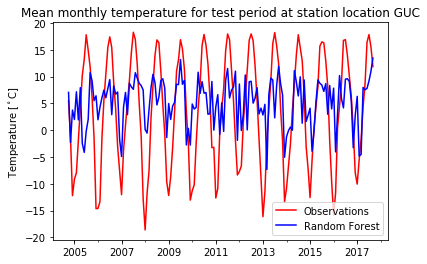

In [109]:
test[['target', 'fit']].plot(style=['r', 'b'])
# ann_predictions['0'].plot(style='r')
plt.legend(labels=['Observations', 'Random Forest', 'Artificial Neural Network'])
plt.ylabel('Temperature [$^\circ$C]')
plt.title('Mean monthly temperature for test period at station location %s' % station_location)
plt.savefig('comparing_methods_AFF_January.png', dpi=250)

In [110]:
rf.feature_importances_

array([0.22898947, 0.05483186, 0.05426253, 0.0684798 , 0.0735651 ,
       0.07135894, 0.07355465, 0.06912436, 0.05007825, 0.1372617 ,
       0.11849334])

## Visualizing a Single Decision Tree

In [81]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = column_names, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 